# Intro to Functional Data

In [1]:
install.packages(c("fda","gridExtra"))


The downloaded binary packages are in
	/var/folders/pd/rg6z0s4n2m5czxdp889kxpkc0000gn/T//RtmpR2XNGJ/downloaded_packages


In [3]:
library(fda)
library(tidyverse)
library(gridExtra)

## Functional Data Example

### Canadian Weather

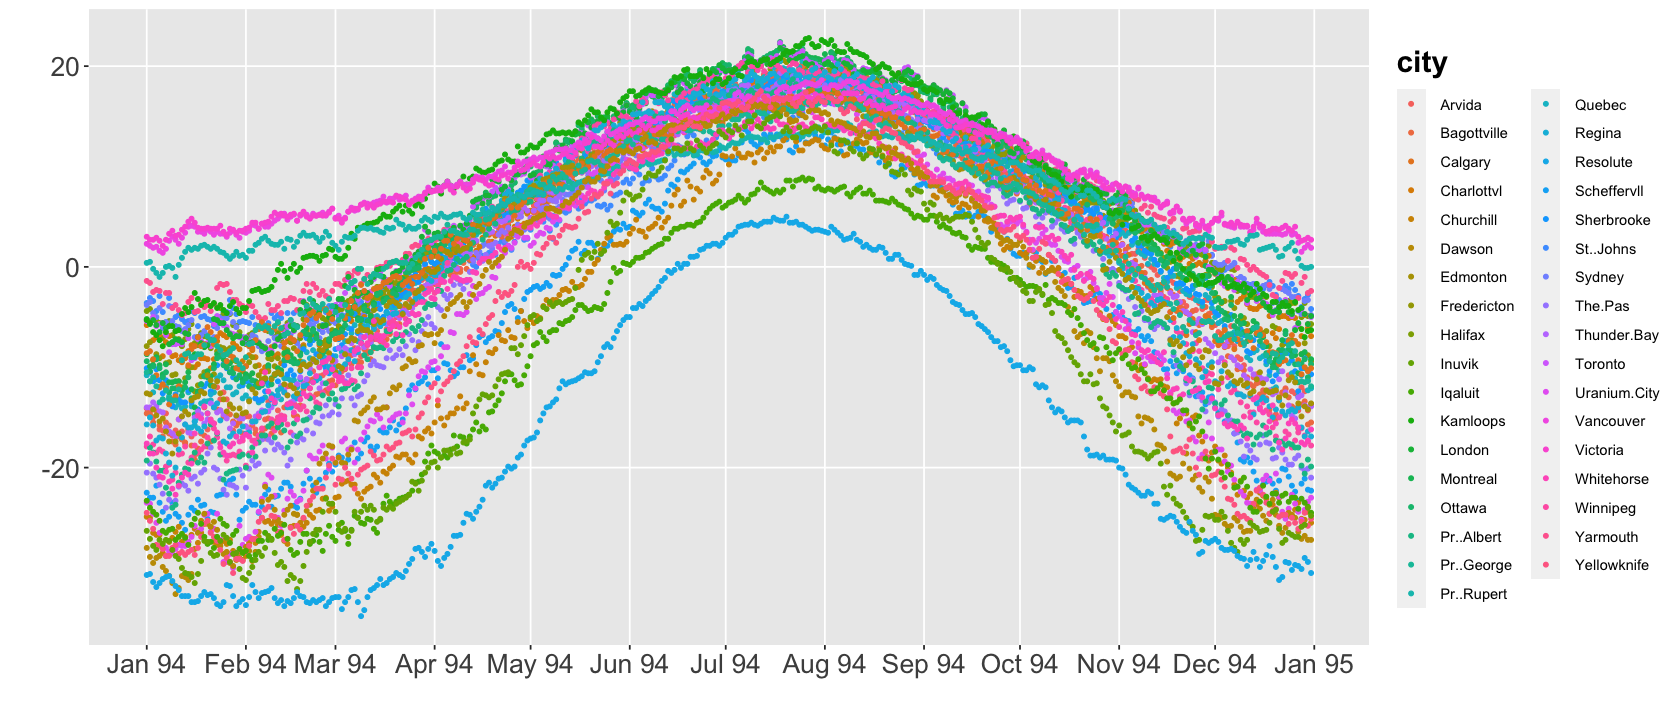

In [4]:
# Plot setting
options(repr.plot.width=14, repr.plot.height=6)
font_theme <- theme(panel.grid.minor = element_blank(), axis.text=element_text(size=16),
                    axis.title=element_text(size=18), title=element_text(size=18,face="bold"))

# Temperature data
weather <- CanadianWeather$dailyAv
temp    <- weather[,,1]
temp.df <- data.frame(temp)
temp.date <- seq(as.Date("1994/1/1"), as.Date("1994/12/31"), by = "day")

# Plot daily temperature
temp.df %>%
  mutate(date = temp.date) %>%
  gather(key = "city", value = "temp", -date) %>%
  ggplot(aes(x = date, y = temp)) +
    geom_point(aes(color = city), size = 1) + 
    scale_x_date(date_labels = "%b %y", date_breaks="month") +
    labs(x="",y="") +
    font_theme -> p1
p1

### Male growth

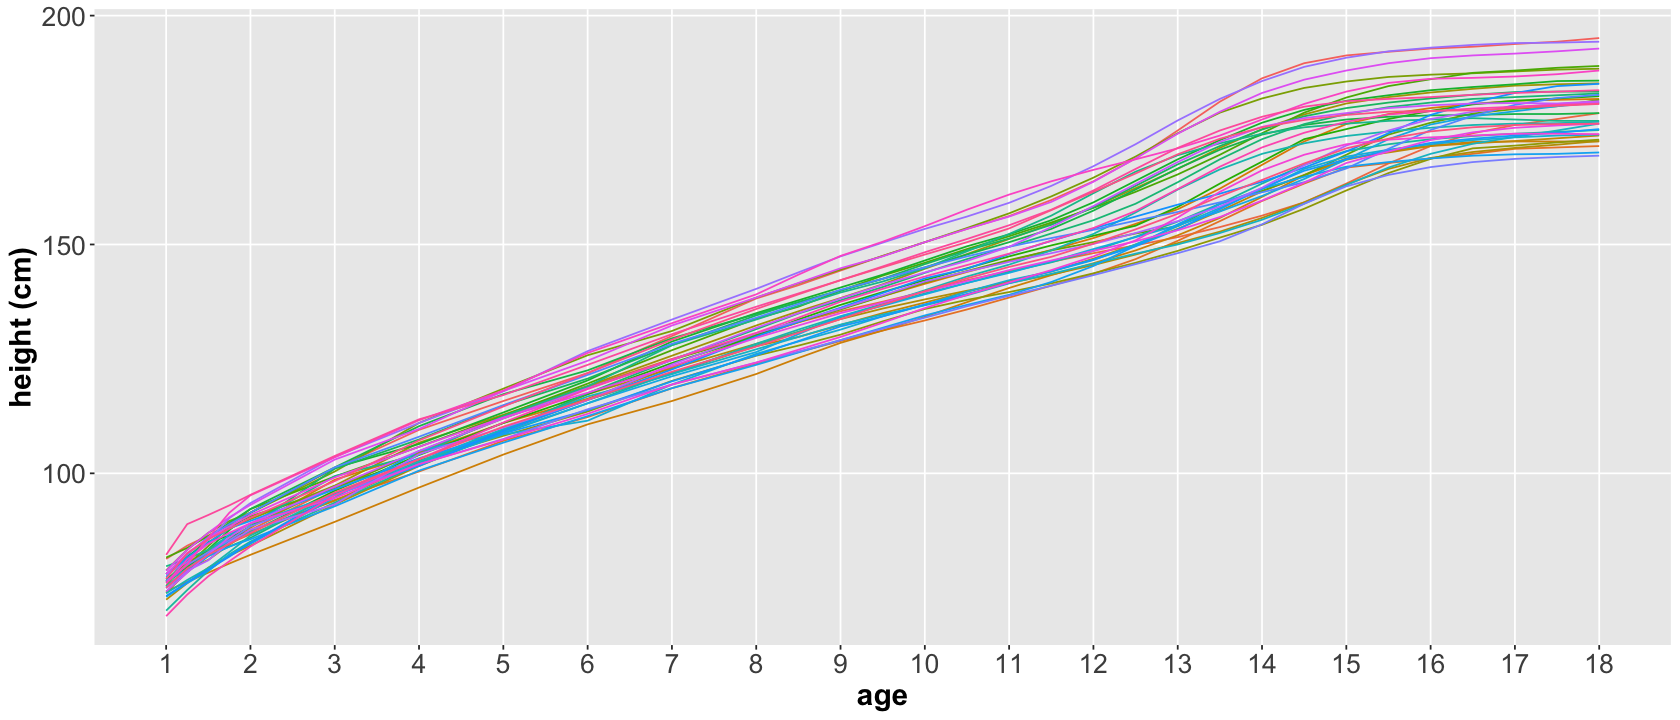

In [5]:
options(repr.plot.width=14, repr.plot.height=6)

mgrowth    <- growth$hgtm
mgrowth.df <- data.frame(mgrowth)
mgrowth.df %>%
  mutate(age=as.numeric(rownames(mgrowth.df))) %>%
  gather(key = "boy", value = "height", -age) %>%
  ggplot(aes(x = age, y = height)) +
    geom_line(aes(color=as.factor(boy))) + 
    labs(x="age",y="height (cm)") + 
    font_theme + theme(legend.position = "none") +
    scale_x_continuous(breaks = seq(1,18), labels = seq(1,18)) -> p2
p2

## Smoothing functional data

### B-Spline Smoothing

In [6]:
BSpline <- function(nbasis,arg=c(0,1),norder=4){
                create.bspline.basis(rangeval=arg,nbasis=nbasis,norder=norder)
           }

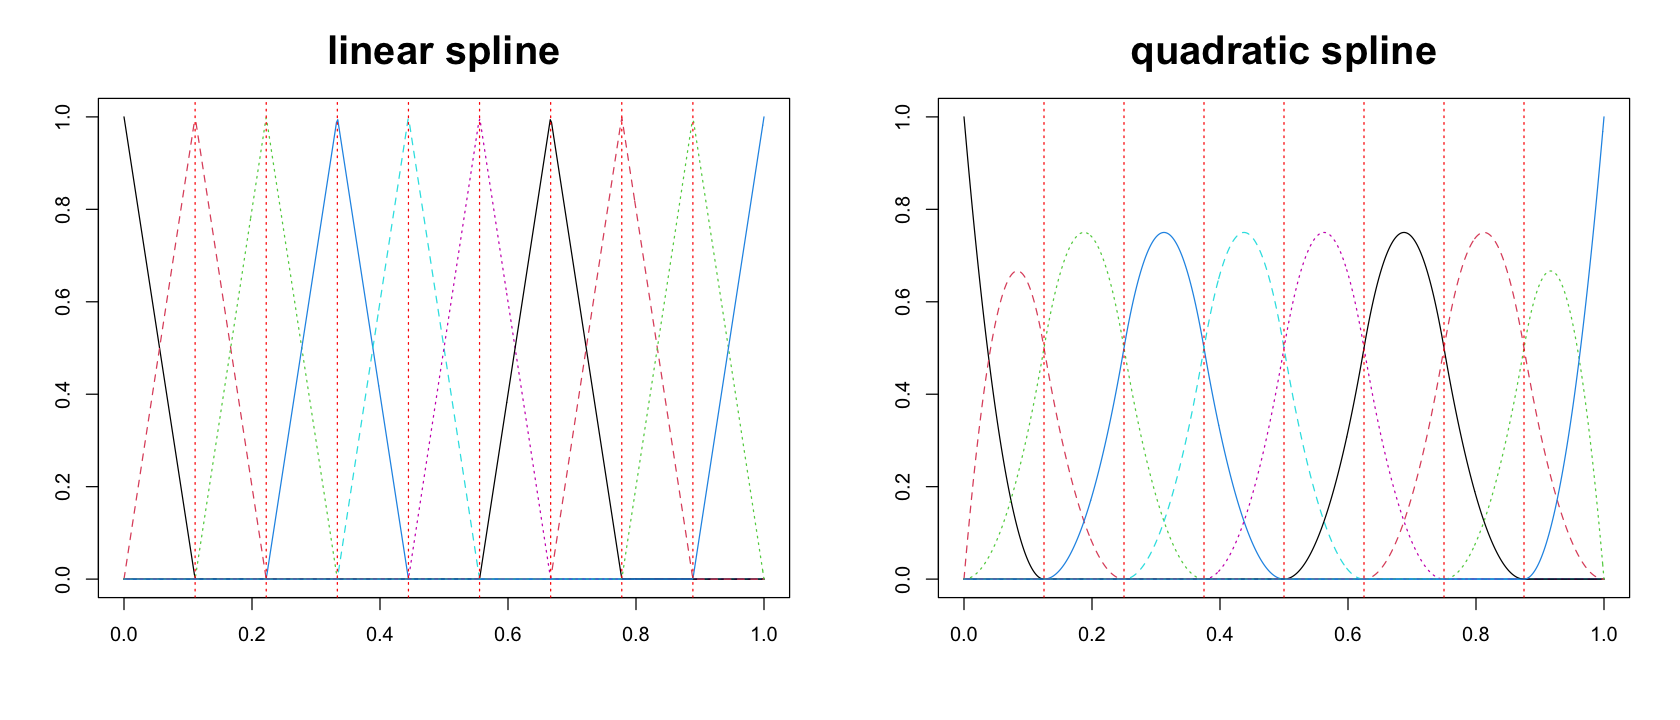

In [7]:
# B-Spline smoothing with different order
options(repr.plot.width=14, repr.plot.height=6)
par(mfrow=c(1,2))
plot(BSpline(10,norder=2)); title("linear spline", cex.main=2)
plot(BSpline(10,norder=3)); title("quadratic spline", cex.main= 2)
par(mfrow=c(1,1))

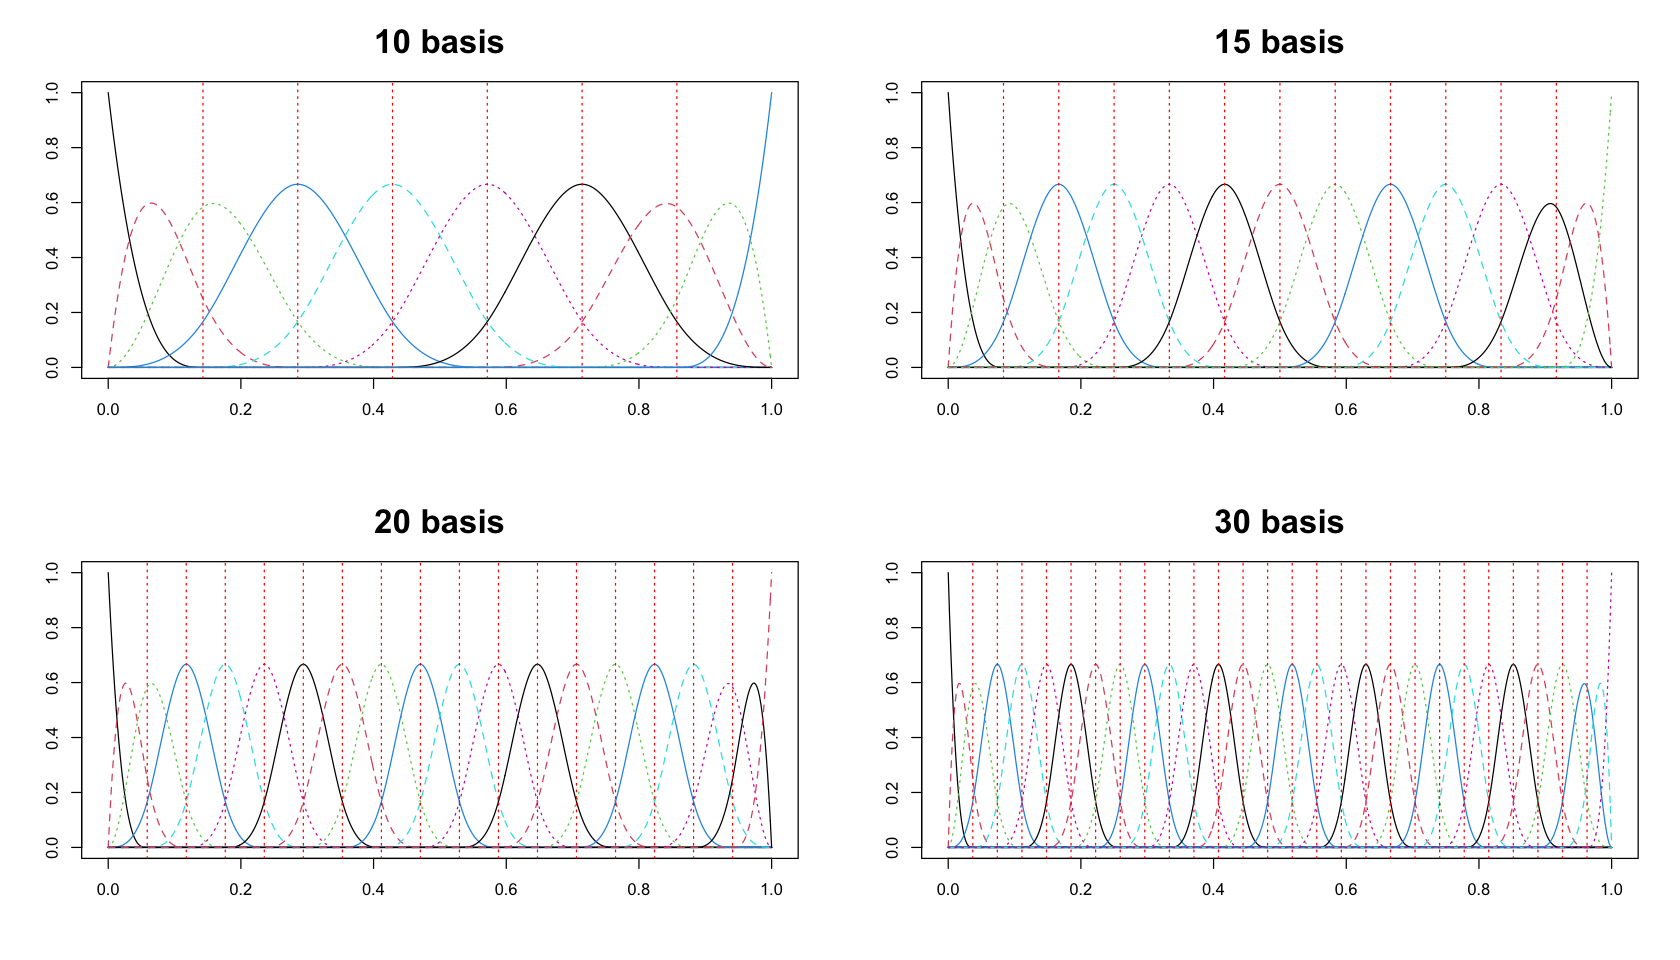

In [8]:
# B-Spline smoothing with 10 basis (cubic spline)
options(repr.plot.width=14, repr.plot.height=8)
par(mfrow=c(2,2))
plot(BSpline(10)); title("10 basis", cex.main= 2)
plot(BSpline(15)); title("15 basis", cex.main= 2)
plot(BSpline(20)); title("20 basis", cex.main= 2)
plot(BSpline(30)); title("30 basis", cex.main= 2)
par(mfrow=c(1,1))

In [9]:
temp.smooth <- smooth.basis(y=temp, fdParobj=BSpline(10,c(1,365)))

[1] "done"

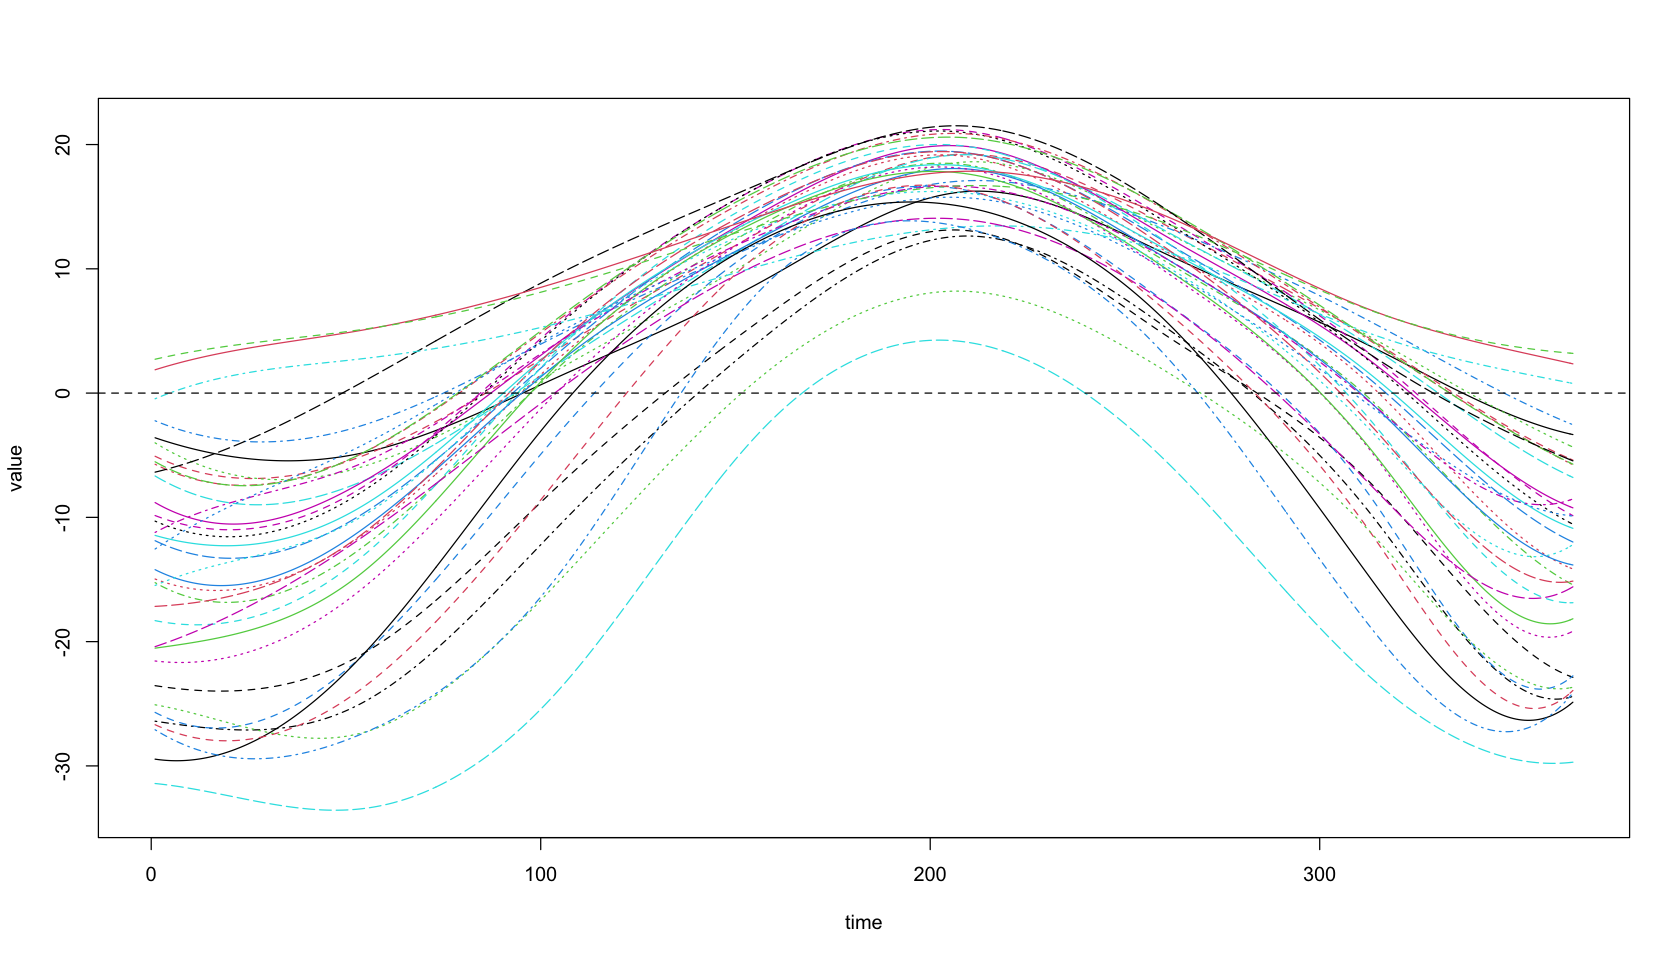

In [10]:
options(repr.plot.width=14, repr.plot.height=8)
plot(temp.smooth)

[1] "done"

[1] "done"

[1] "done"

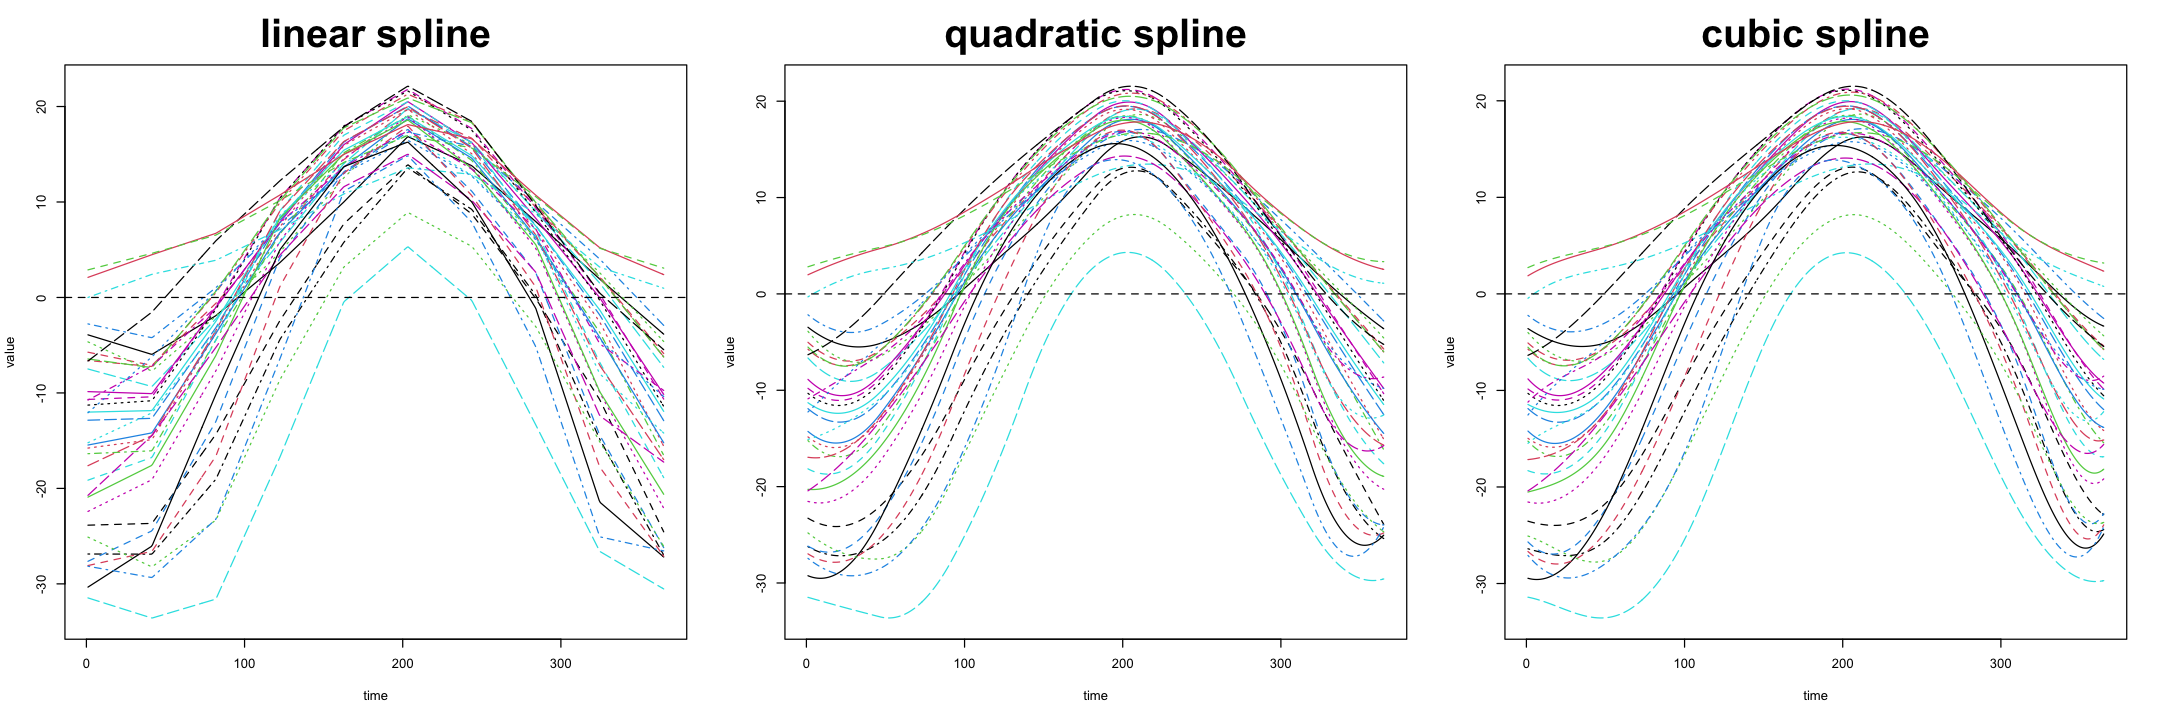

In [11]:
temp.smooth2 <- smooth.basis(y=temp, fdParobj=BSpline(10,c(1,365),2))
temp.smooth3 <- smooth.basis(y=temp, fdParobj=BSpline(10,c(1,365),3))

options(repr.plot.width=18, repr.plot.height=6)
par(mfrow=c(1,3))
plot(temp.smooth2, main="a"); title(main="linear spline", cex.main= 3)
plot(temp.smooth3); title("quadratic spline", cex.main= 3)
plot(temp.smooth); title("cubic spline", cex.main= 3)
par(mfrow=c(1,1))

[1] "done"

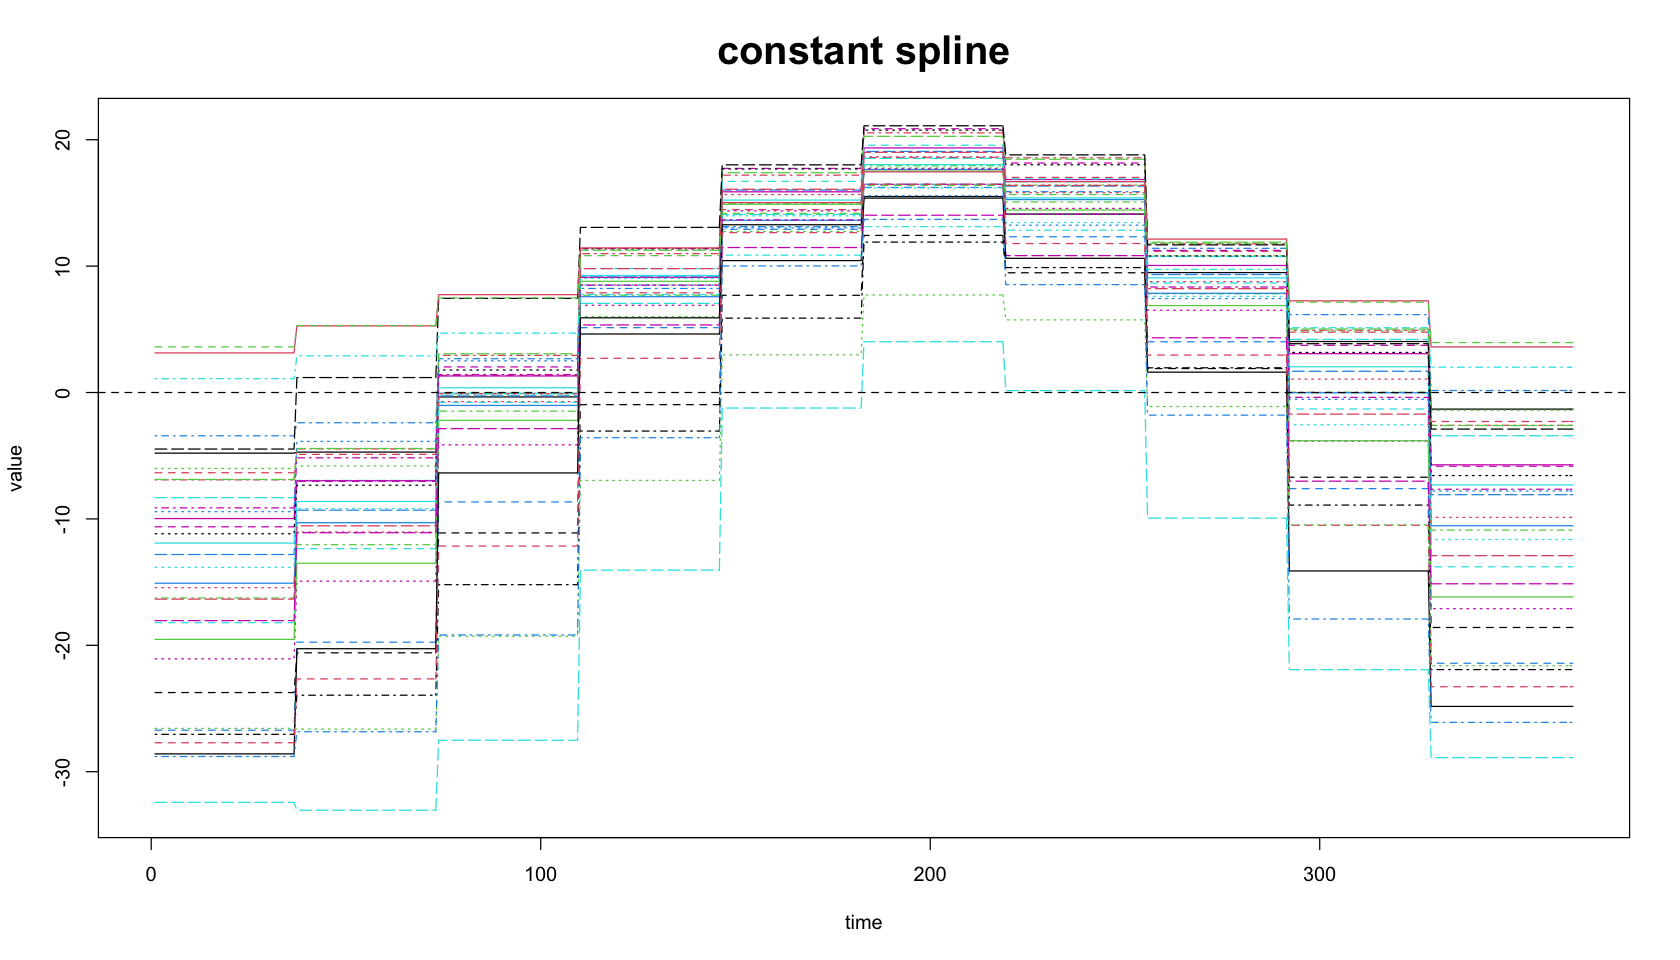

In [13]:
temp.smooth0 <- smooth.basis(y=temp, fdParobj=BSpline(10,c(1,365),1))
options(repr.plot.width=14, repr.plot.height=8)
plot(temp.smooth0); title("constant spline", cex.main= 2)
par(mfrow=c(1,1))

In [14]:
mgrowth.smooth <- smooth.basis(argvals=growth$age, y=mgrowth, fdParobj=BSpline(10,c(1,18)))

[1] "done"

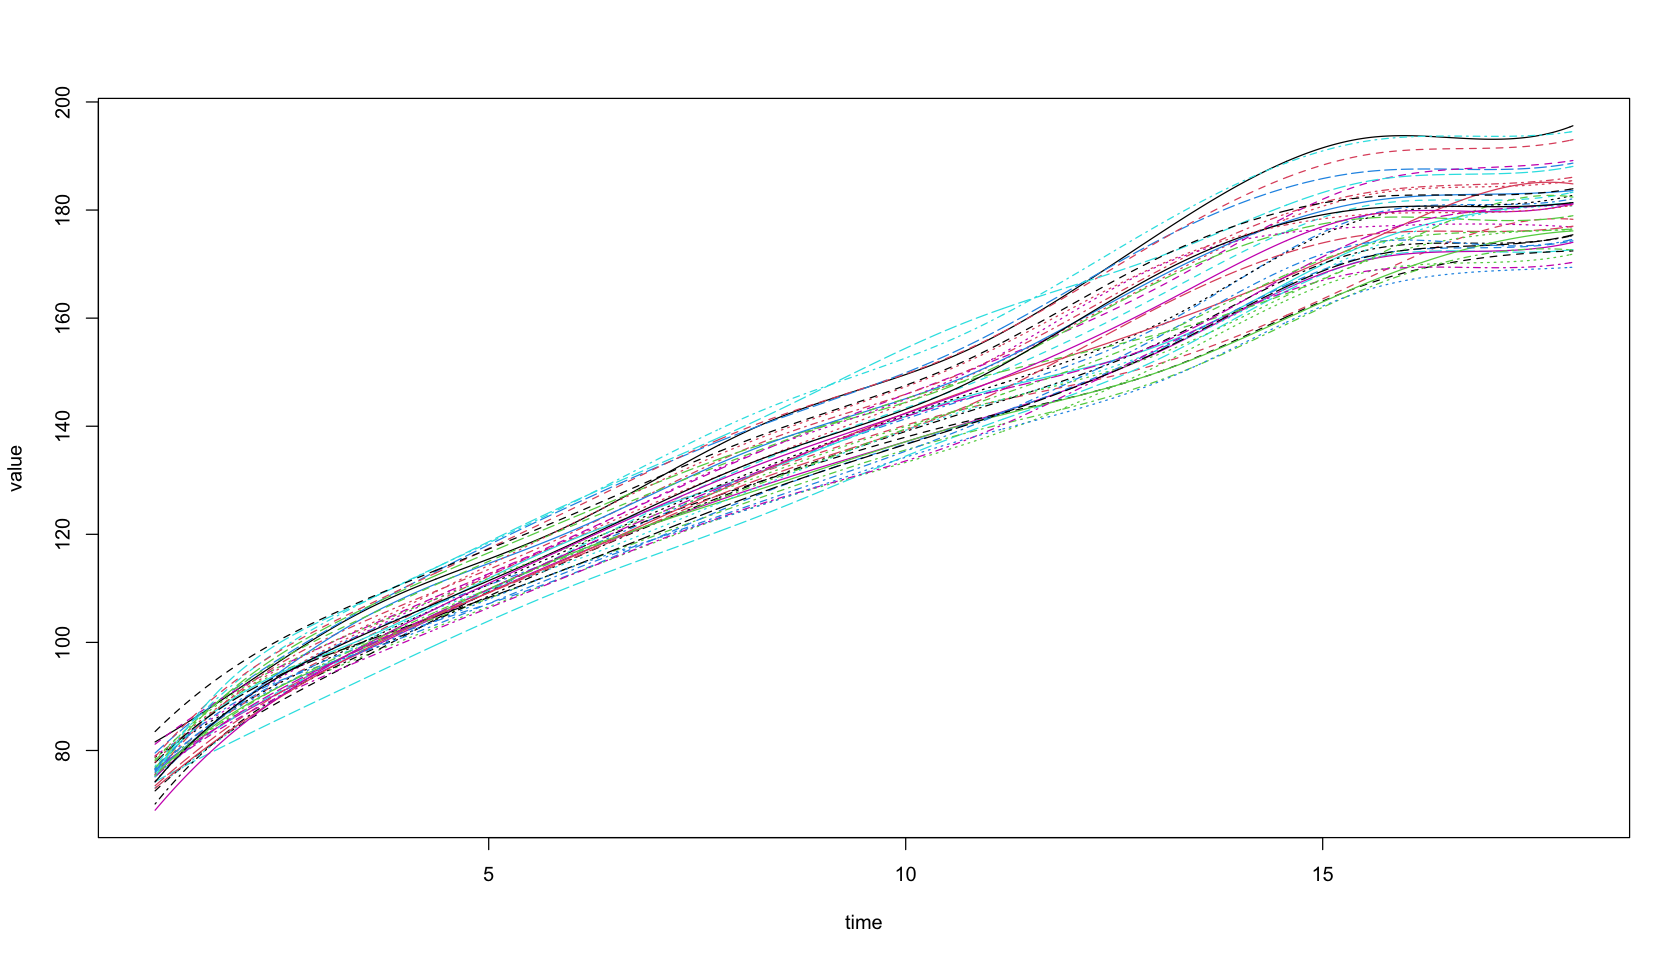

In [15]:
options(repr.plot.width=14, repr.plot.height=8)
plot(mgrowth.smooth)

### Smoothing Wiener process using B-Spline

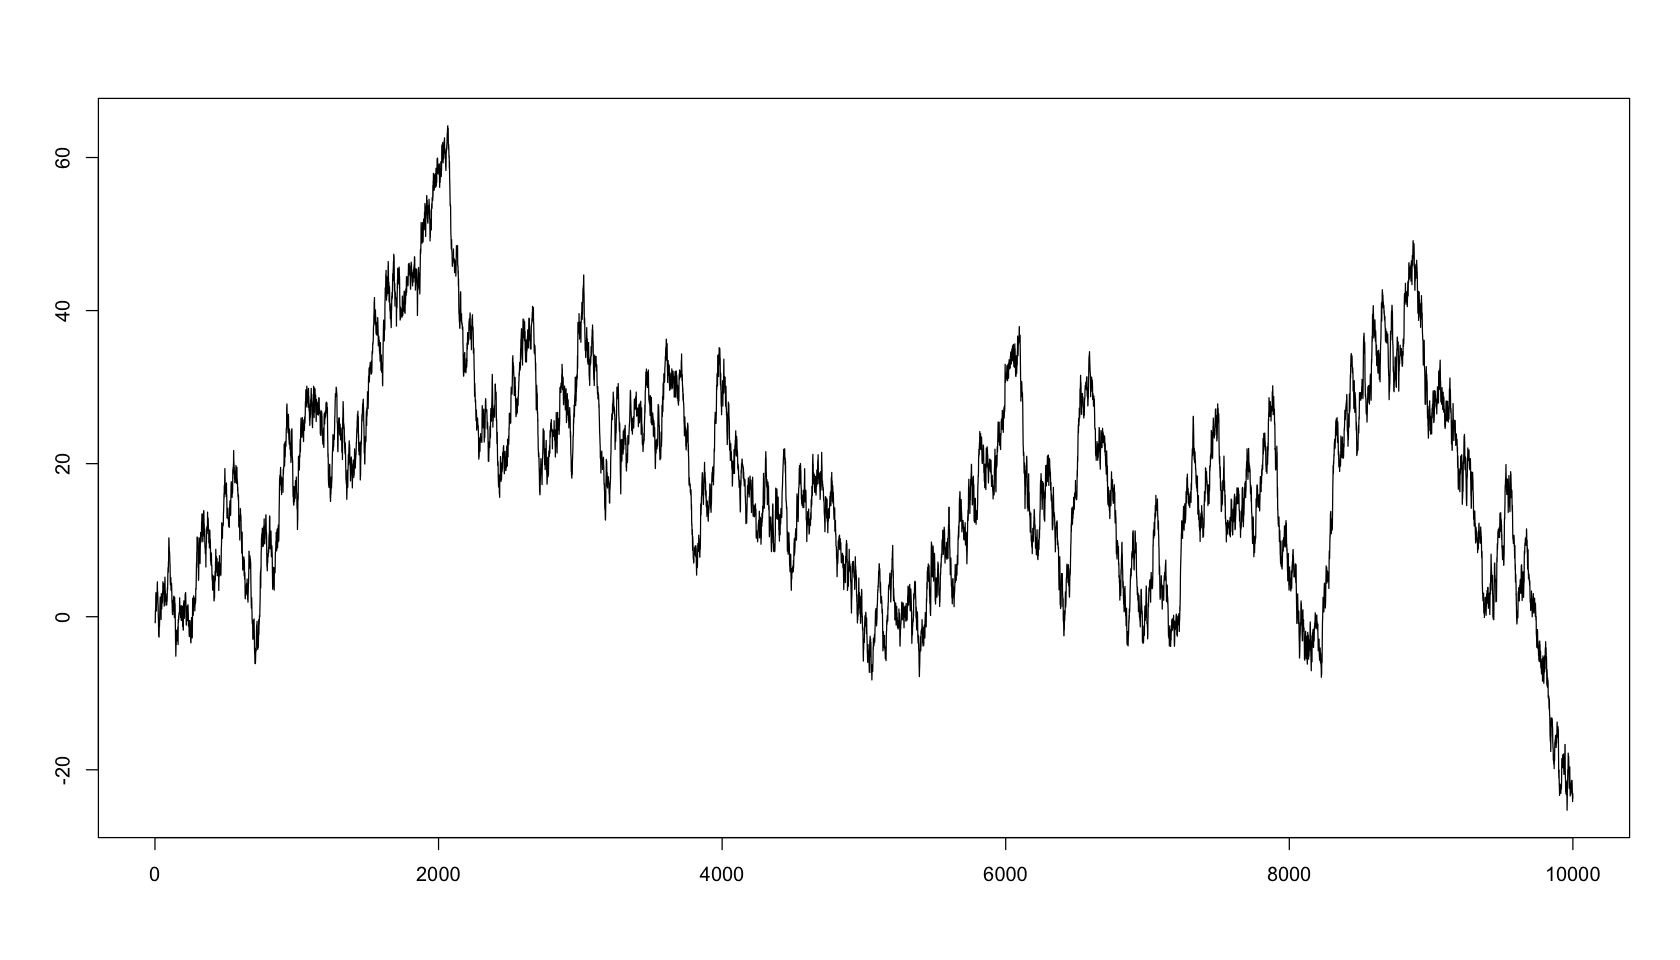

In [16]:
set.seed(123)
K <- 10000
Wiener <- cumsum(rnorm(K)) # random walk on [0,K], K=10ˆ4
options(repr.plot.width=14, repr.plot.height=8)
plot.ts(Wiener, xlab="", ylab="")

In [17]:
Wiener.smooth <- smooth.basis(y=Wiener, fdParobj=BSpline(20,c(1,K)))
Wiener.fitted <- eval.fd(1:K, Wiener.smooth$fd)

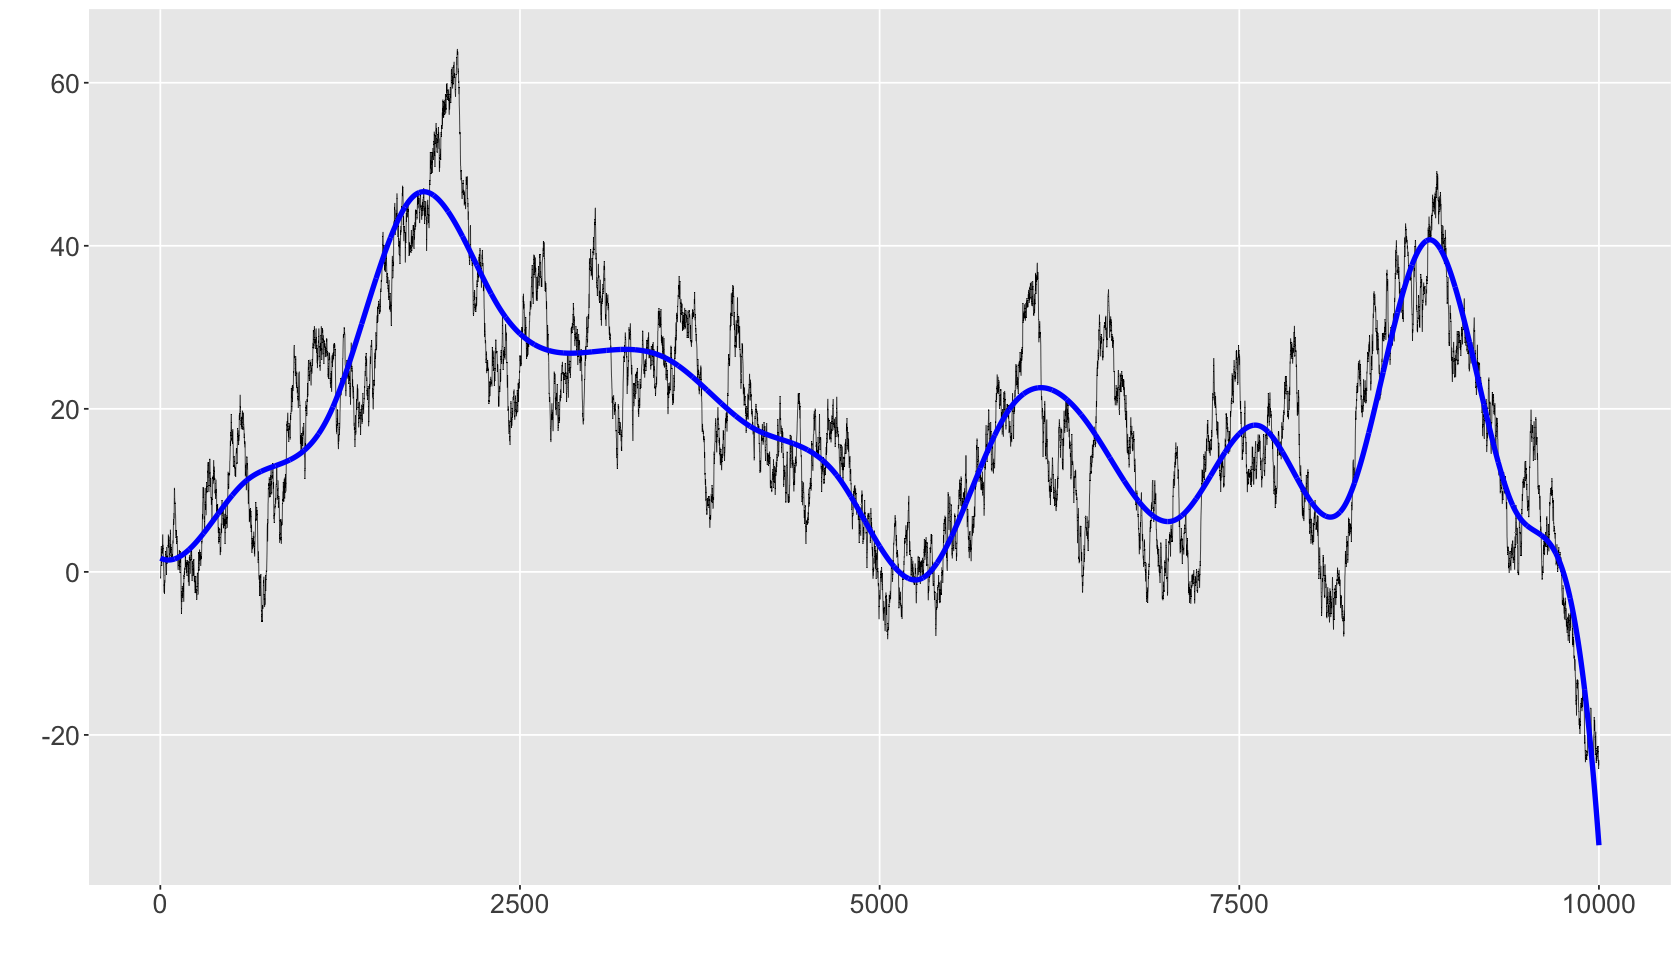

In [18]:
options(repr.plot.width=14, repr.plot.height=8)
ggplot(data = data.frame(actual=Wiener,fitted=Wiener.fitted,t=1:K)) +
    geom_line(aes(x=t,y=actual), color="black", size=0.2) +
    geom_line(aes(x=t,y=fitted), color="blue", size=1.5) +
    labs(x="",y="") + font_theme

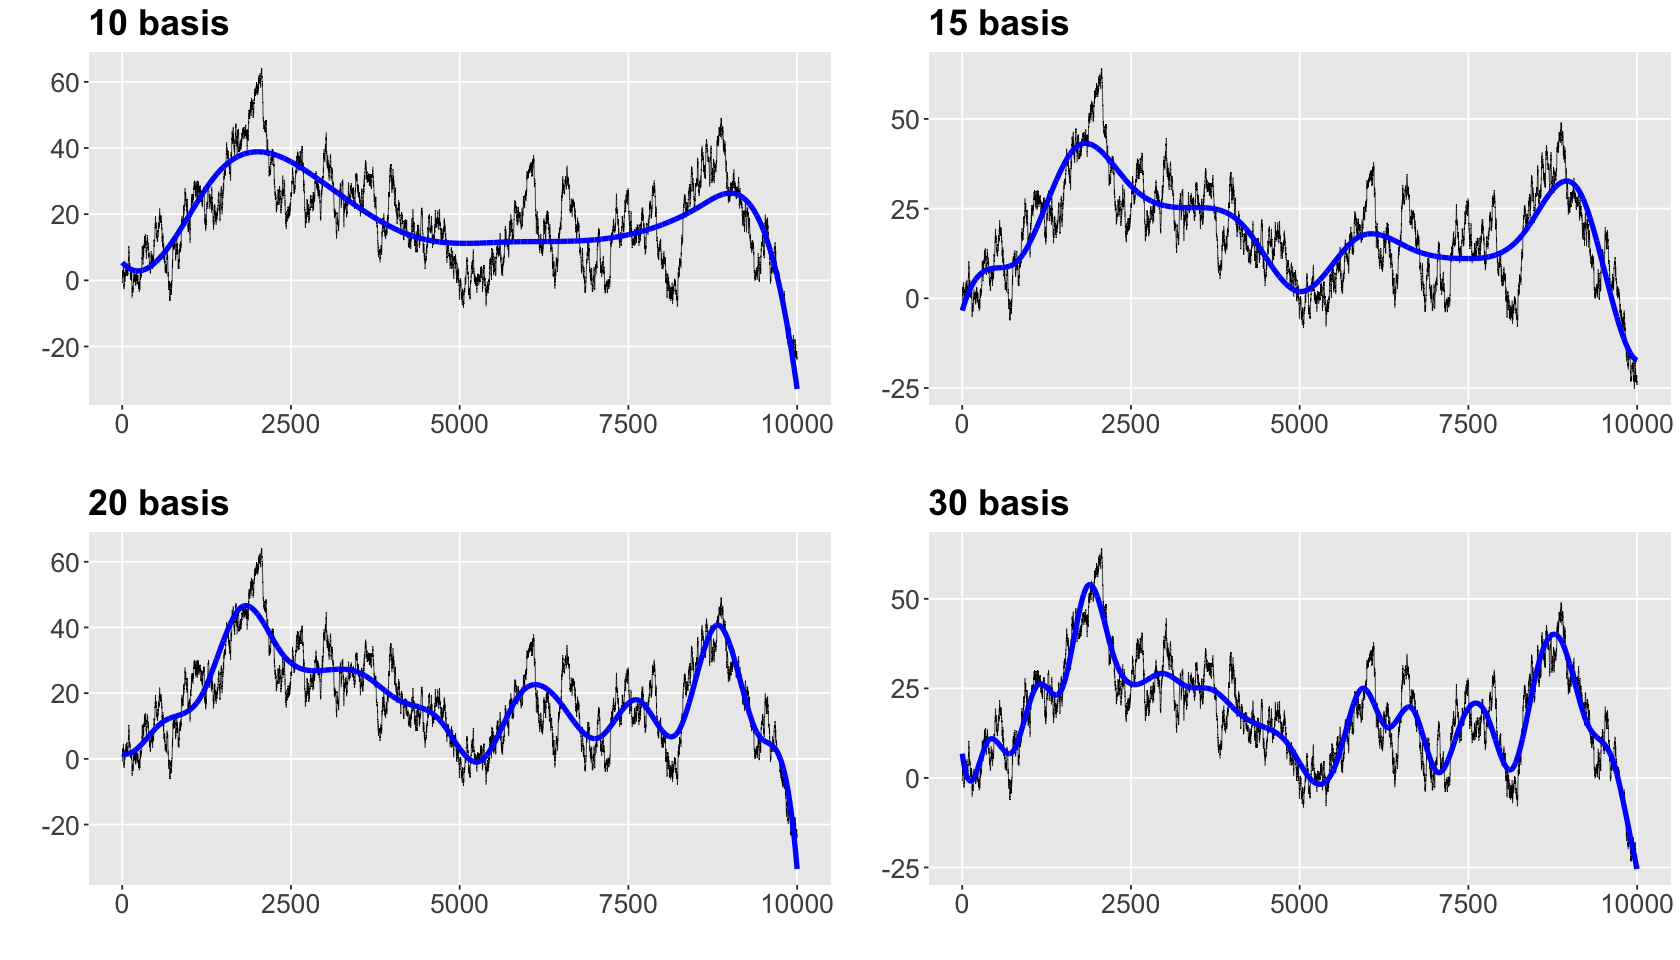

In [19]:
# Compare different number of basis

Wiener.plot <- function(data, basis){
  K <- length(data)
  smooth <- smooth.basis(y=data, fdParobj=BSpline(basis,c(1,K)))
  fitted <- eval.fd(1:K, smooth$fd)
  p <- ggplot(data = data.frame(actual=data,fitted=fitted,t=1:K)) +
        geom_line(aes(x=t,y=actual), color="black", size=0.2) +
        geom_line(aes(x=t,y=fitted), color="blue", size=1.5) +
        labs(x="",y="", title = paste0(basis," basis")) + font_theme
  return(p)
}
grid.arrange(Wiener.plot(Wiener,10),
             Wiener.plot(Wiener,15),
             Wiener.plot(Wiener,20),
             Wiener.plot(Wiener,30), nrow=2)

### Fourier Basis Smoothing (Periodic data)

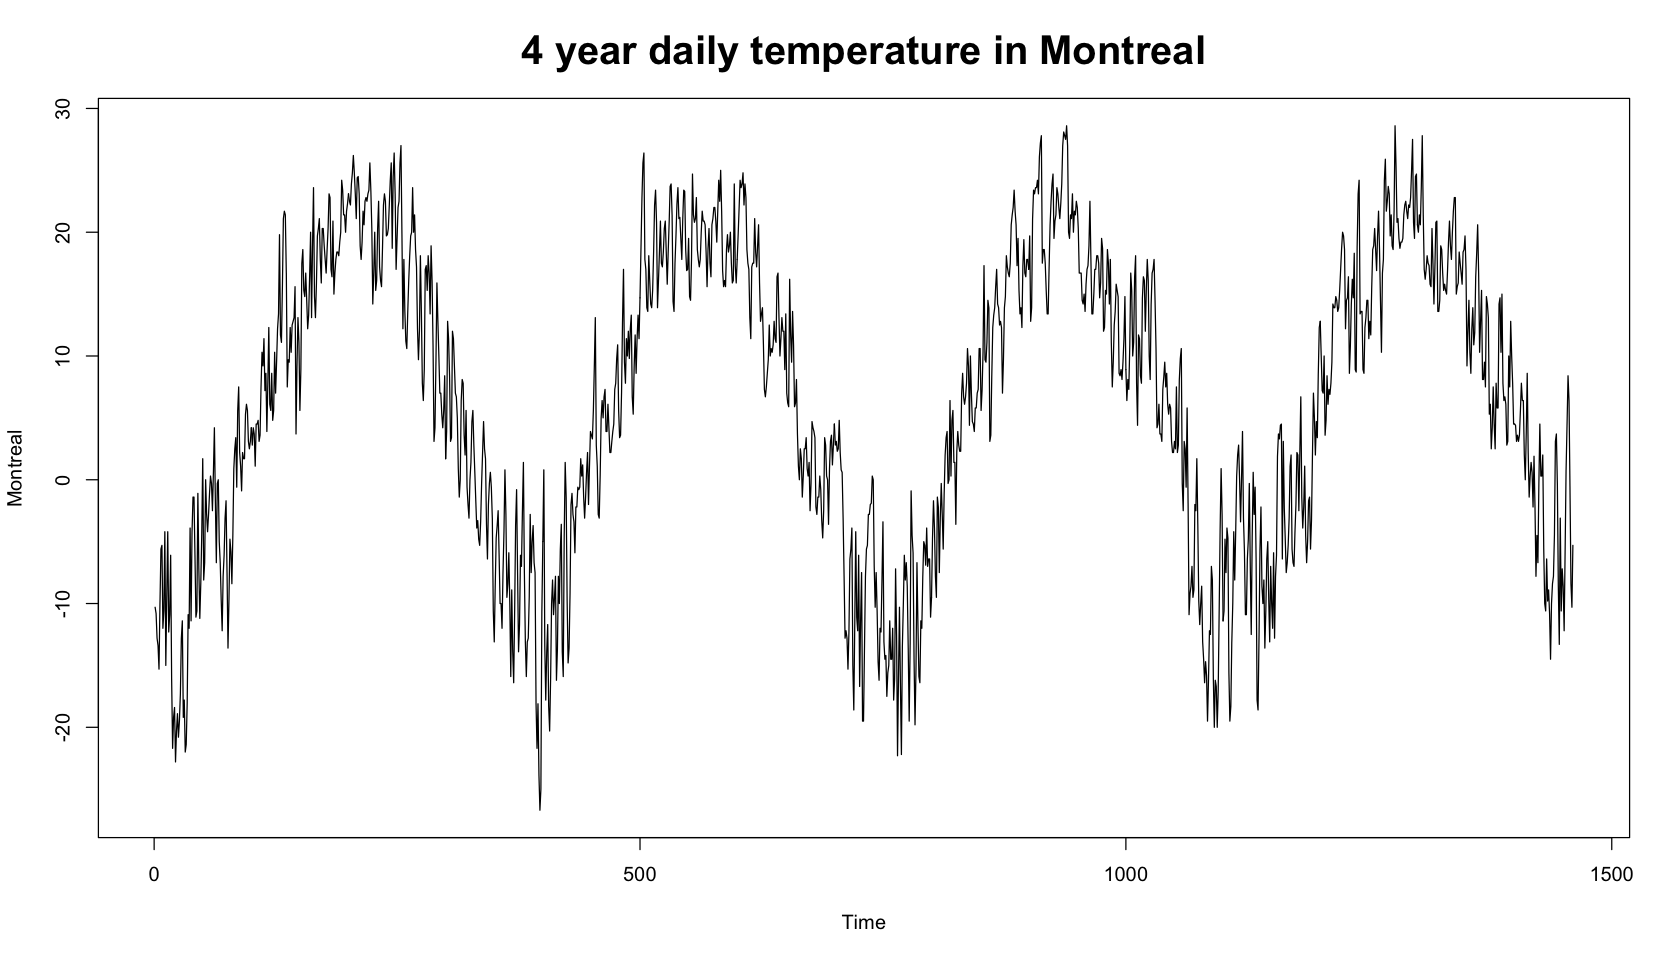

In [20]:
data(MontrealTemp)
Montreal <- c(MontrealTemp[1,], MontrealTemp[2,], MontrealTemp[3,], MontrealTemp[4,])
options(repr.plot.width=14, repr.plot.height=8)
ts.plot(Montreal)
title("4 year daily temperature in Montreal", cex.main=2)

[1] "done"

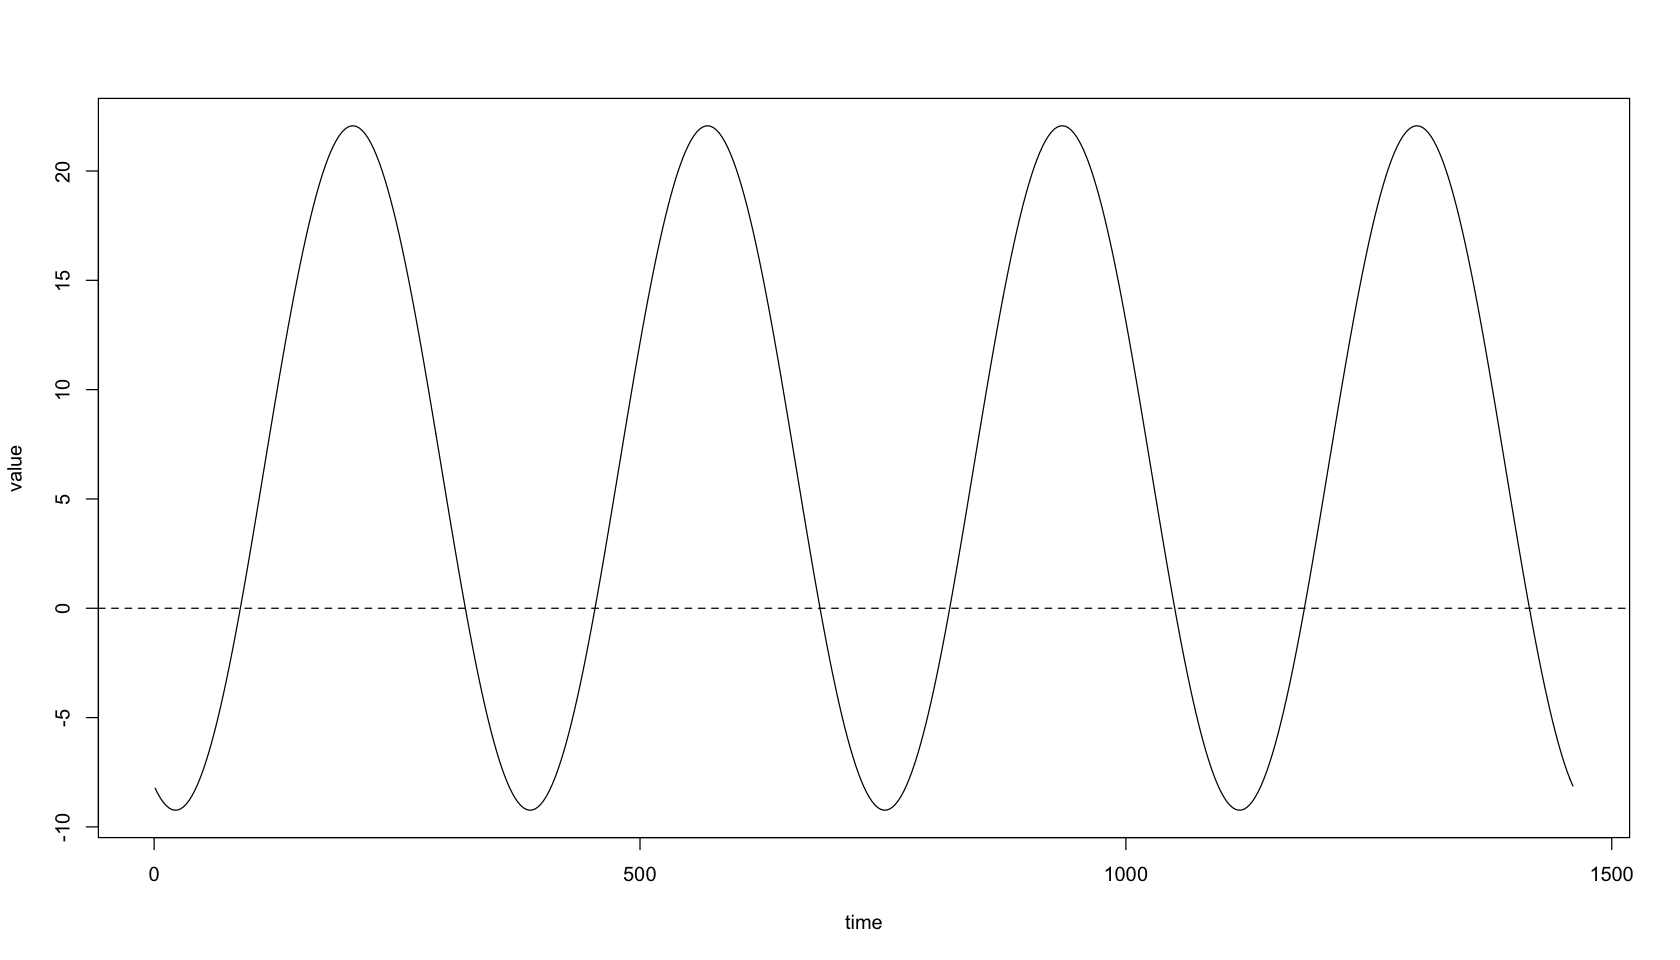

In [21]:
Fourier <- create.fourier.basis(c(1,365*4),nbasis=2, period=365)
Montreal.smooth <- smooth.basis(y=Montreal, fdParobj=Fourier)
Montreal.fitted <- eval.fd(seq(1,4*365), Montreal.smooth$fd)

options(repr.plot.width=14, repr.plot.height=8)
plot(Montreal.smooth)

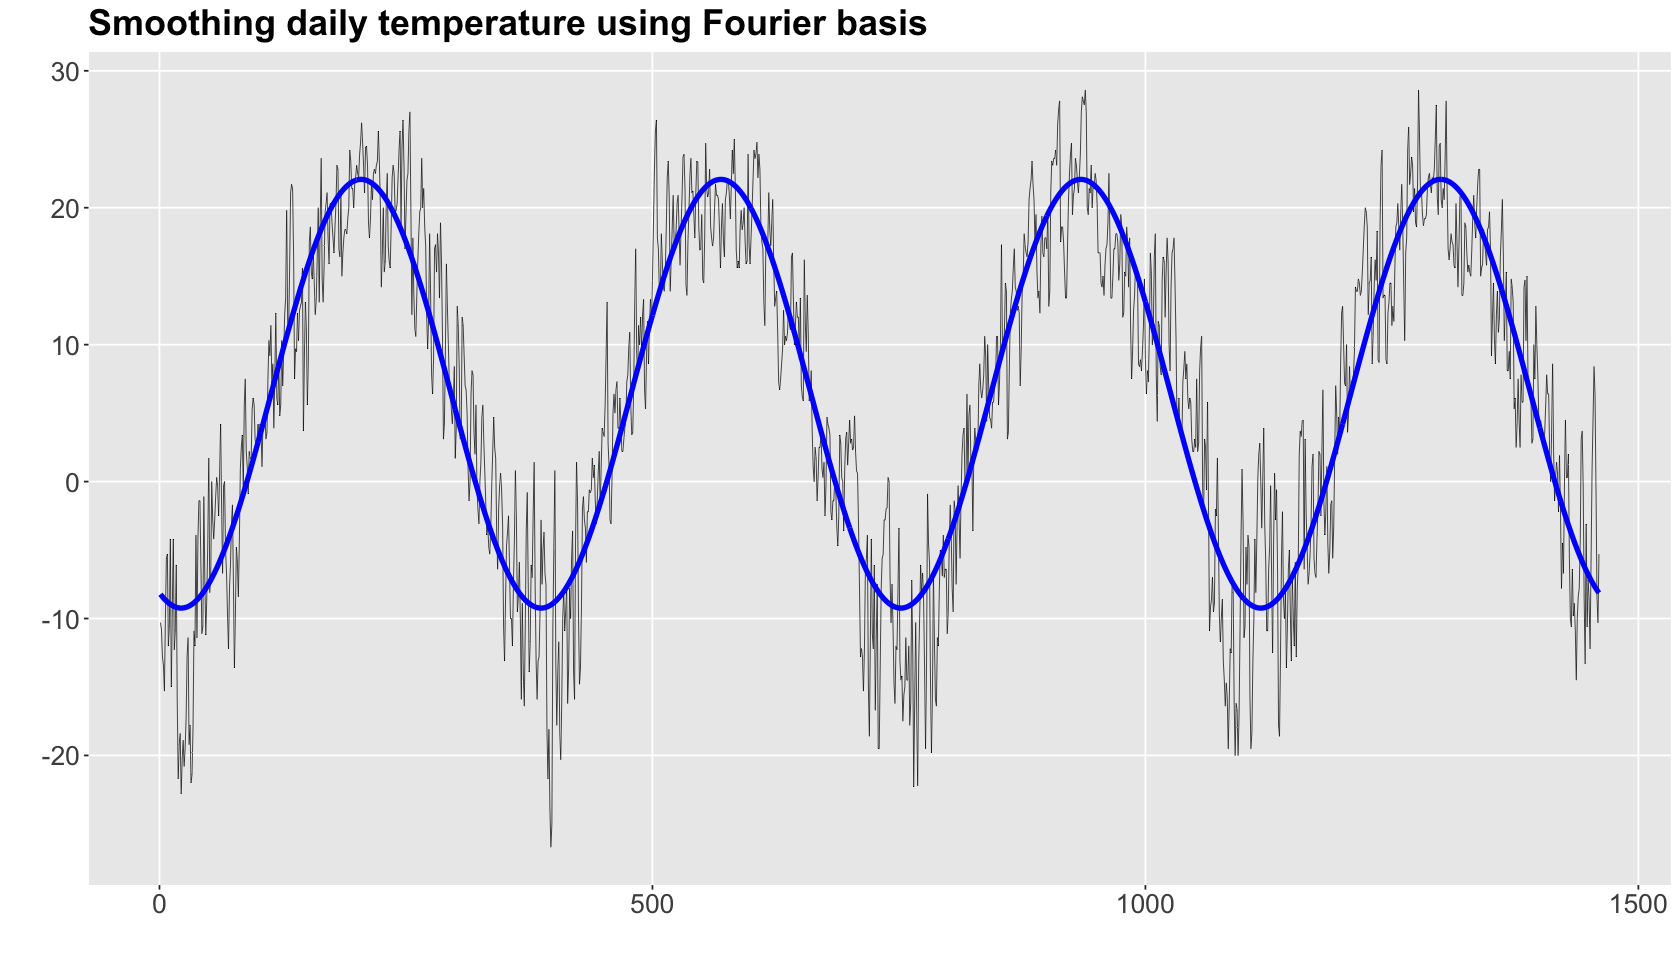

In [22]:
options(repr.plot.width=14, repr.plot.height=8)
ggplot(data = data.frame(actual=Montreal,fitted=Montreal.fitted,t=seq(1,4*365))) +
    geom_line(aes(x=t,y=actual), color="black", size=0.2) +
    geom_line(aes(x=t,y=fitted), color="blue", size=1.5) +
    labs(x="",y="", title="Smoothing daily temperature using Fourier basis") + 
    font_theme

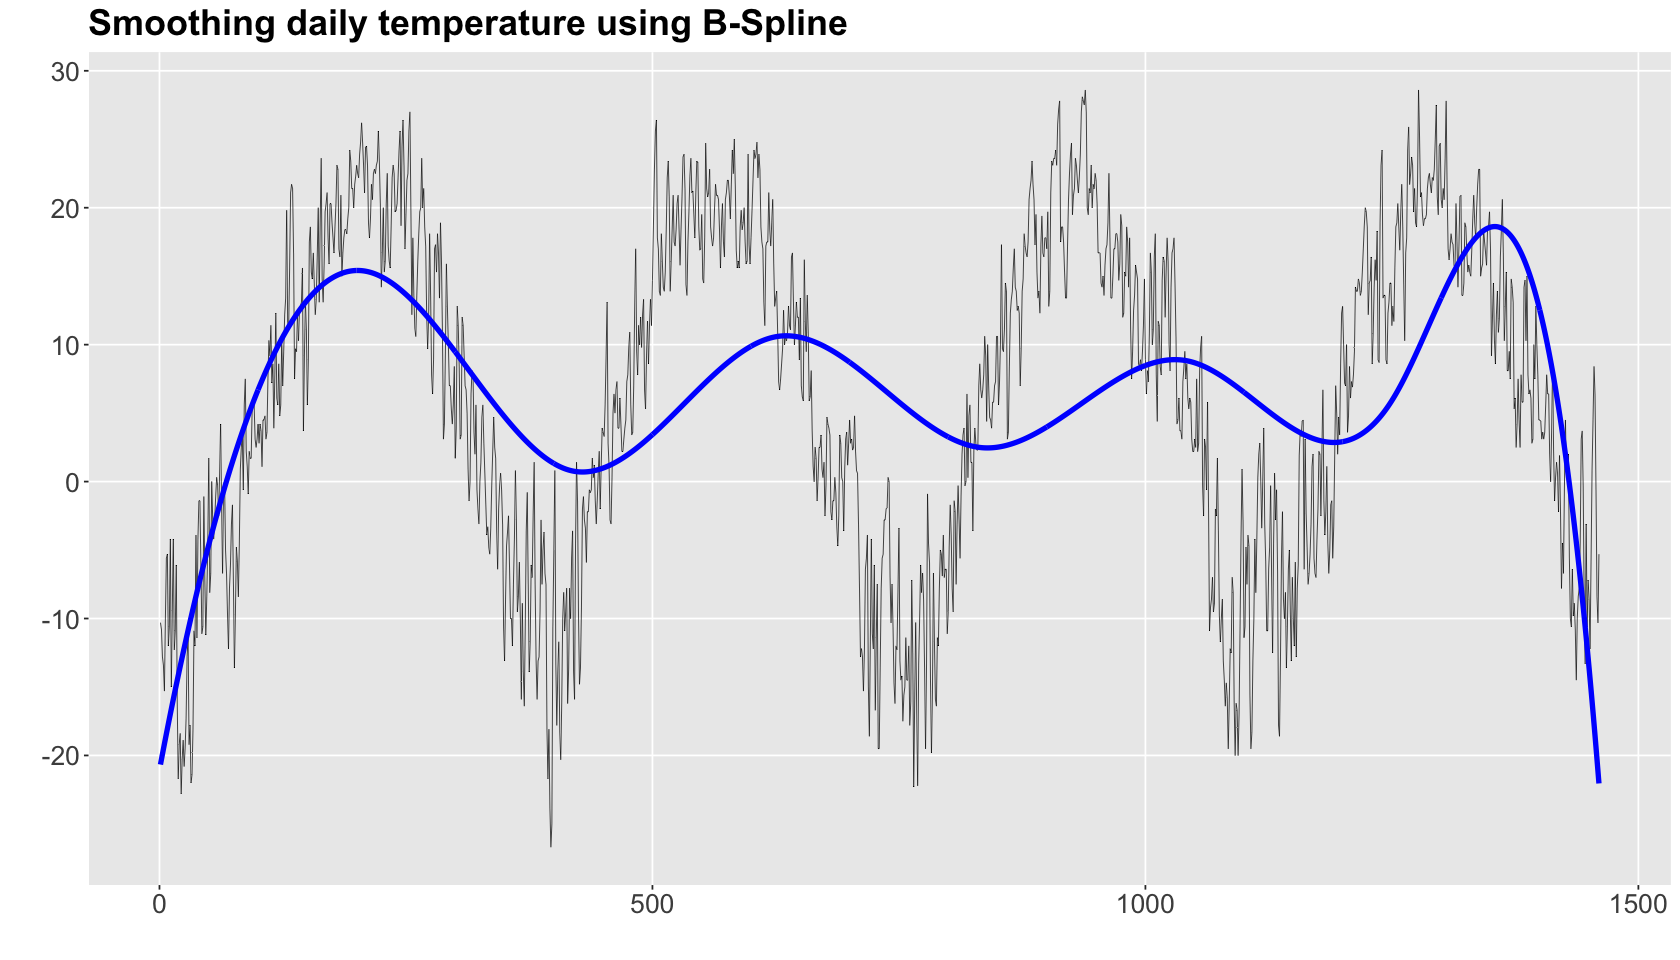

In [23]:
Montreal.smooth2 <- smooth.basis(y=Montreal, fdParobj=BSpline(10,c(1,4*365)))
Montreal.fitted2 <- eval.fd(seq(1,4*365), Montreal.smooth2$fd)

options(repr.plot.width=14, repr.plot.height=8)
ggplot(data = data.frame(actual=Montreal,fitted=Montreal.fitted2,t=seq(1,4*365))) +
    geom_line(aes(x=t,y=actual), color="black", size=0.2) +
    geom_line(aes(x=t,y=fitted), color="blue", size=1.5) +
    labs(x="",y="", title="Smoothing daily temperature using B-Spline") + 
    font_theme

## Derivative of functional data

### Growth rate and accelaration

In [24]:
mgrowth.deriv <- deriv.fd(mgrowth.smooth$fd,1)
mgrowth.deriv2 <- deriv.fd(mgrowth.smooth$fd,2)

[1] "done"

[1] "done"

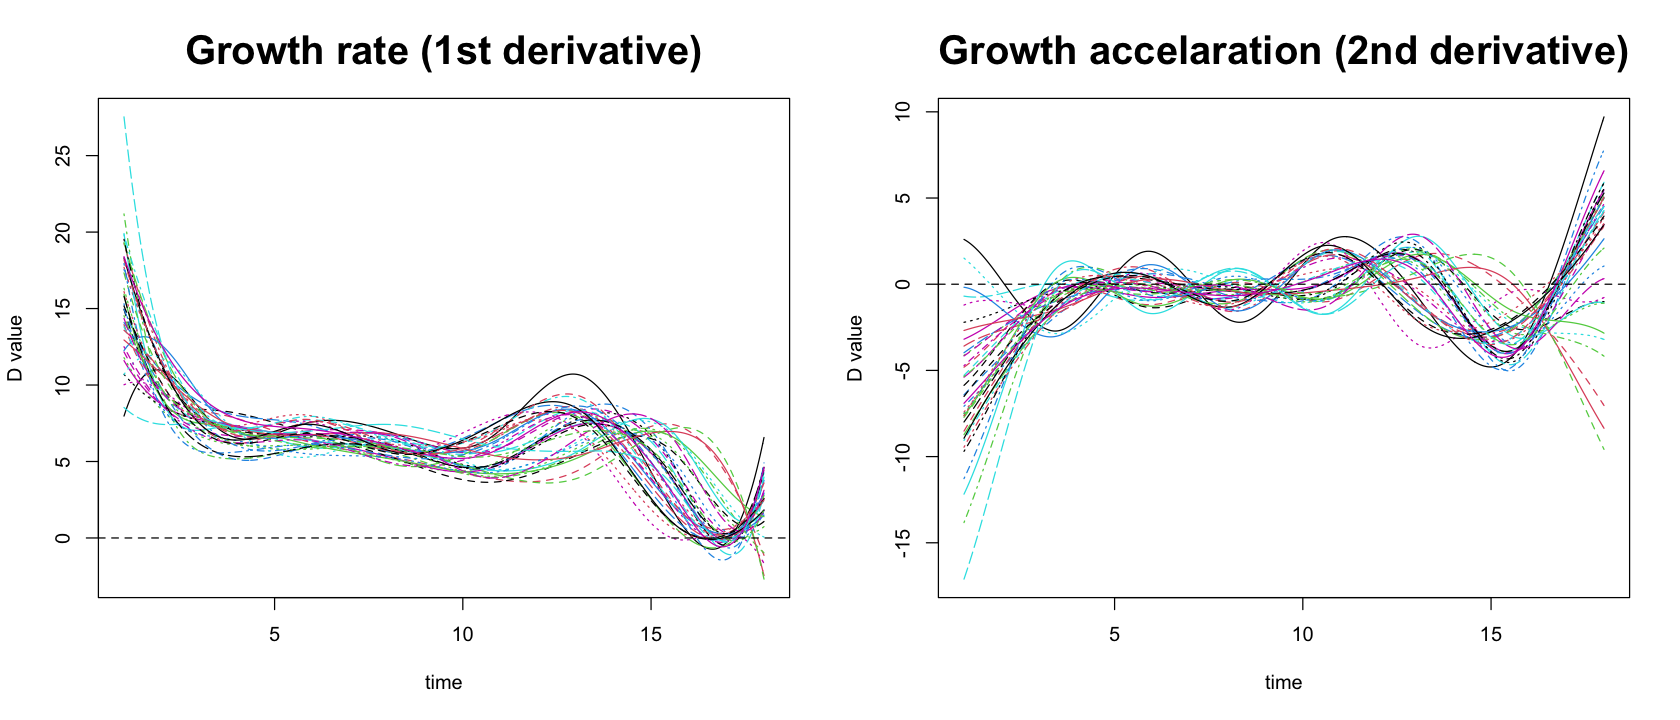

In [25]:
options(repr.plot.width=14, repr.plot.height=6)
par(mfrow=c(1,2))
plot(mgrowth.deriv); title("Growth rate (1st derivative)", cex.main= 2)
plot(mgrowth.deriv2); title("Growth accelaration (2nd derivative)", cex.main= 2)
par(mfrow=c(1,1))

### Rate of temperature change

[1] "done"

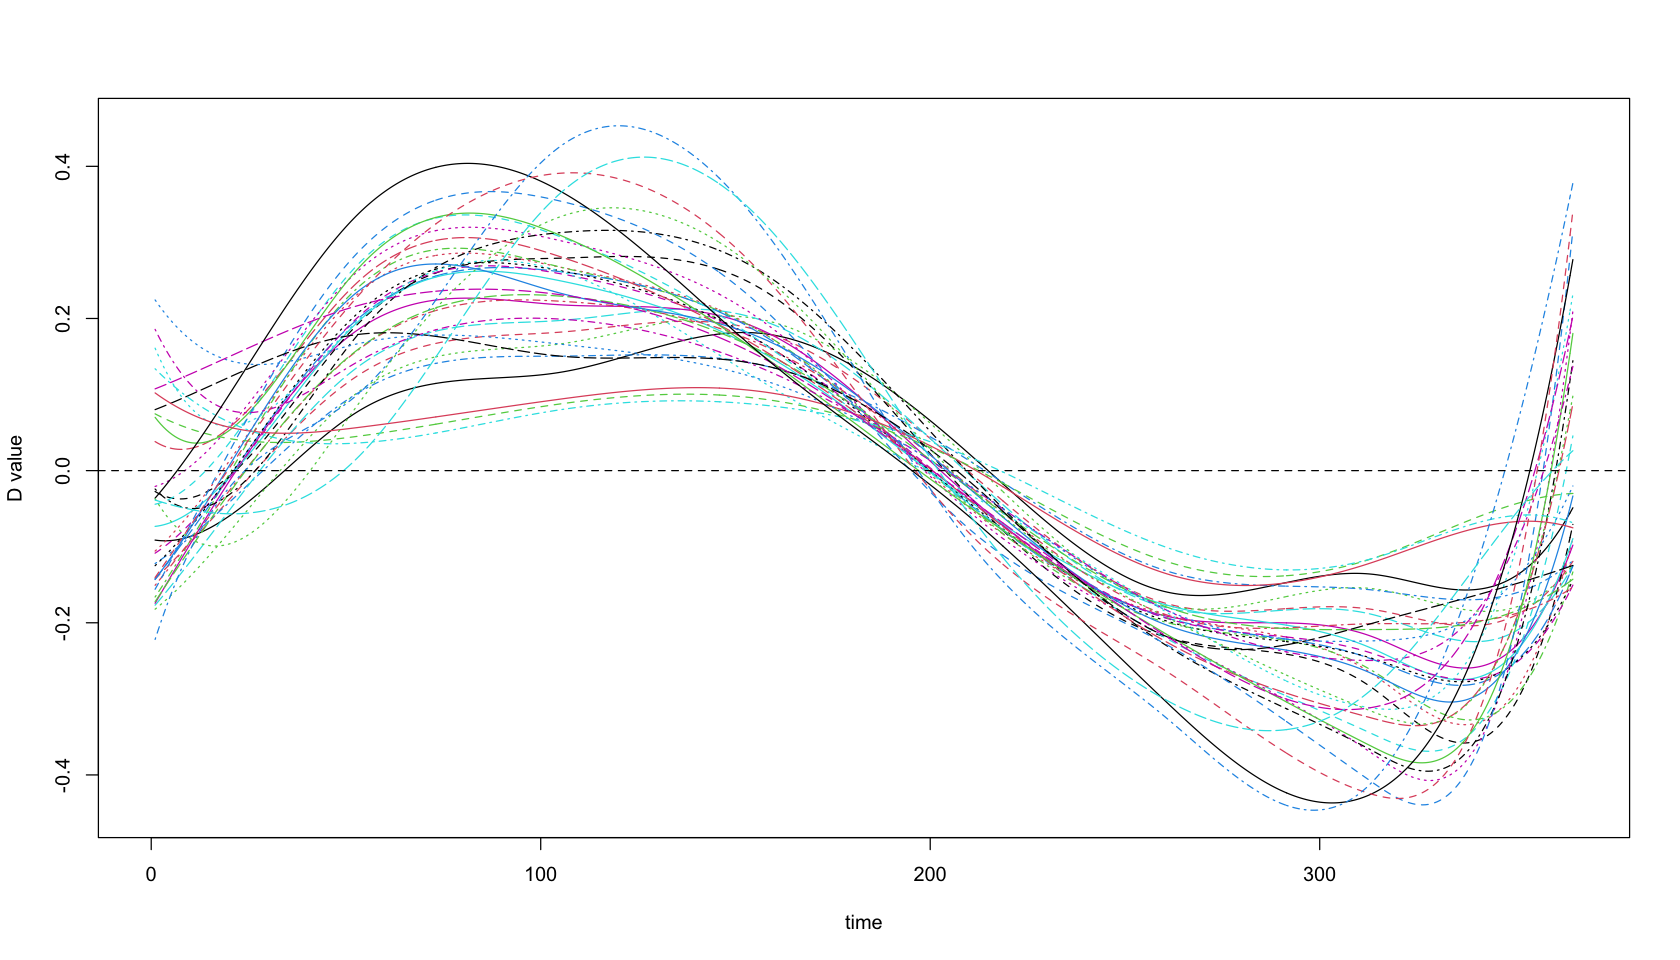

In [26]:
temp.deriv <- deriv.fd(temp.smooth$fd,1)
options(repr.plot.width=14, repr.plot.height=8)
plot(temp.deriv)

## Summary Statistics for Functional Data

### Functional Mean

[1] "done"

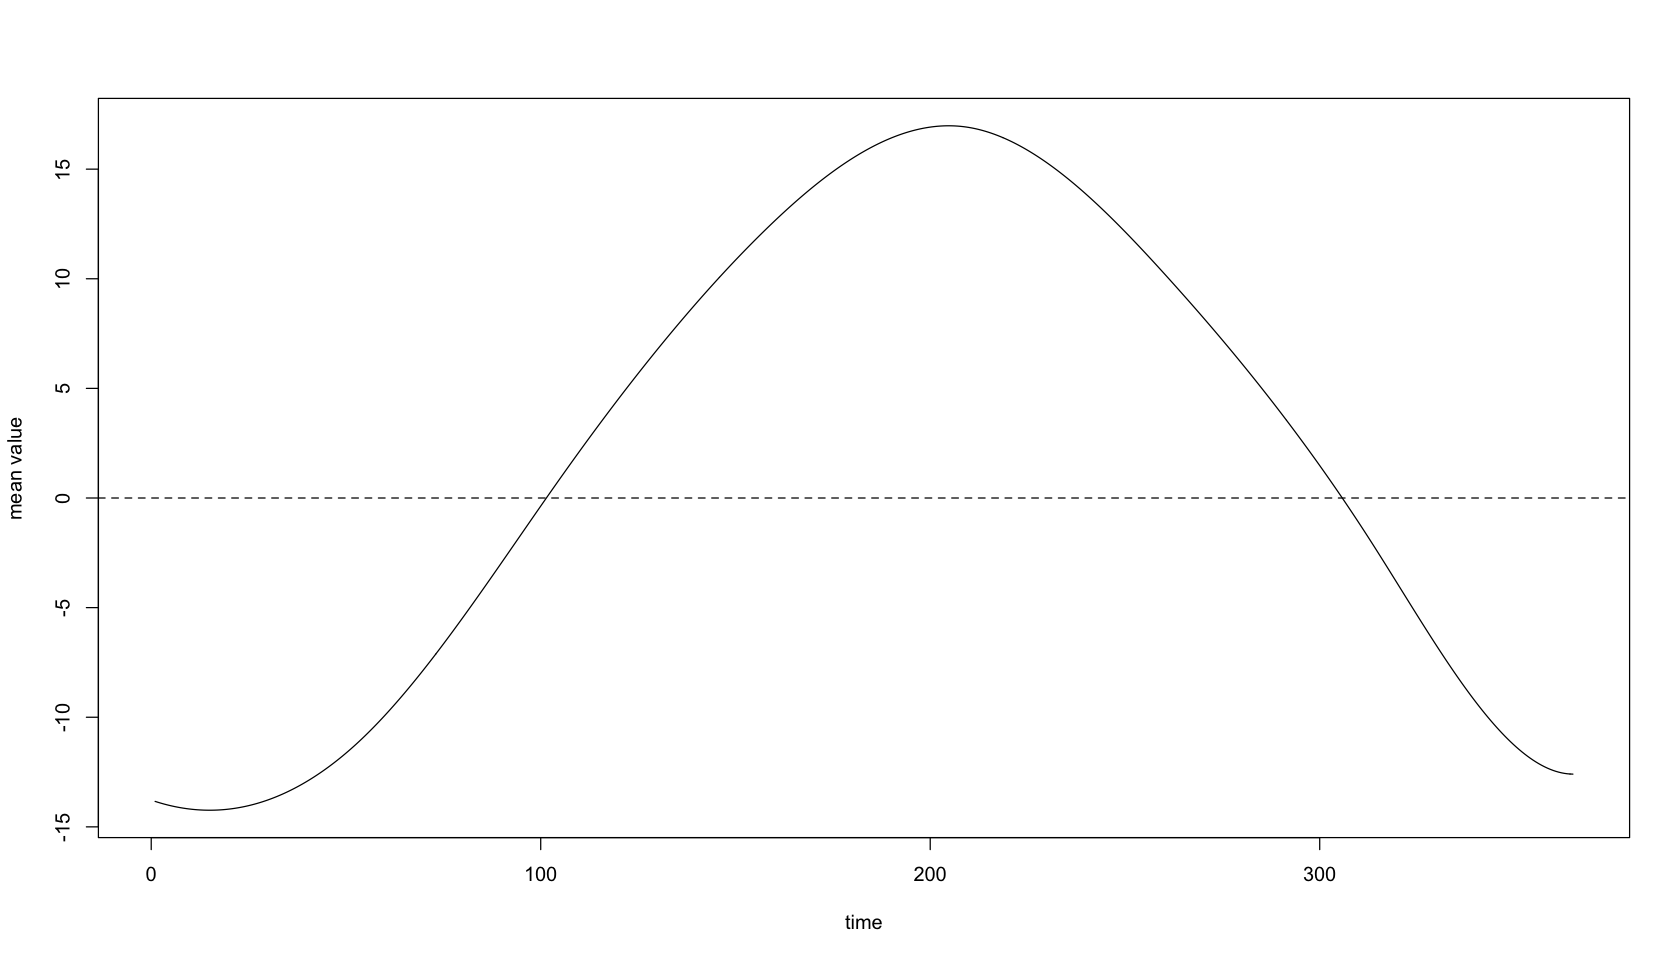

In [27]:
temp.mean <- mean.fd(temp.smooth$fd)
options(repr.plot.width=14, repr.plot.height=8)
plot(temp.mean)

In [28]:
temp.fitted <- eval.fd(1:365, temp.smooth$fd)
temp.mean.fitted <- eval.fd(1:365, temp.mean)

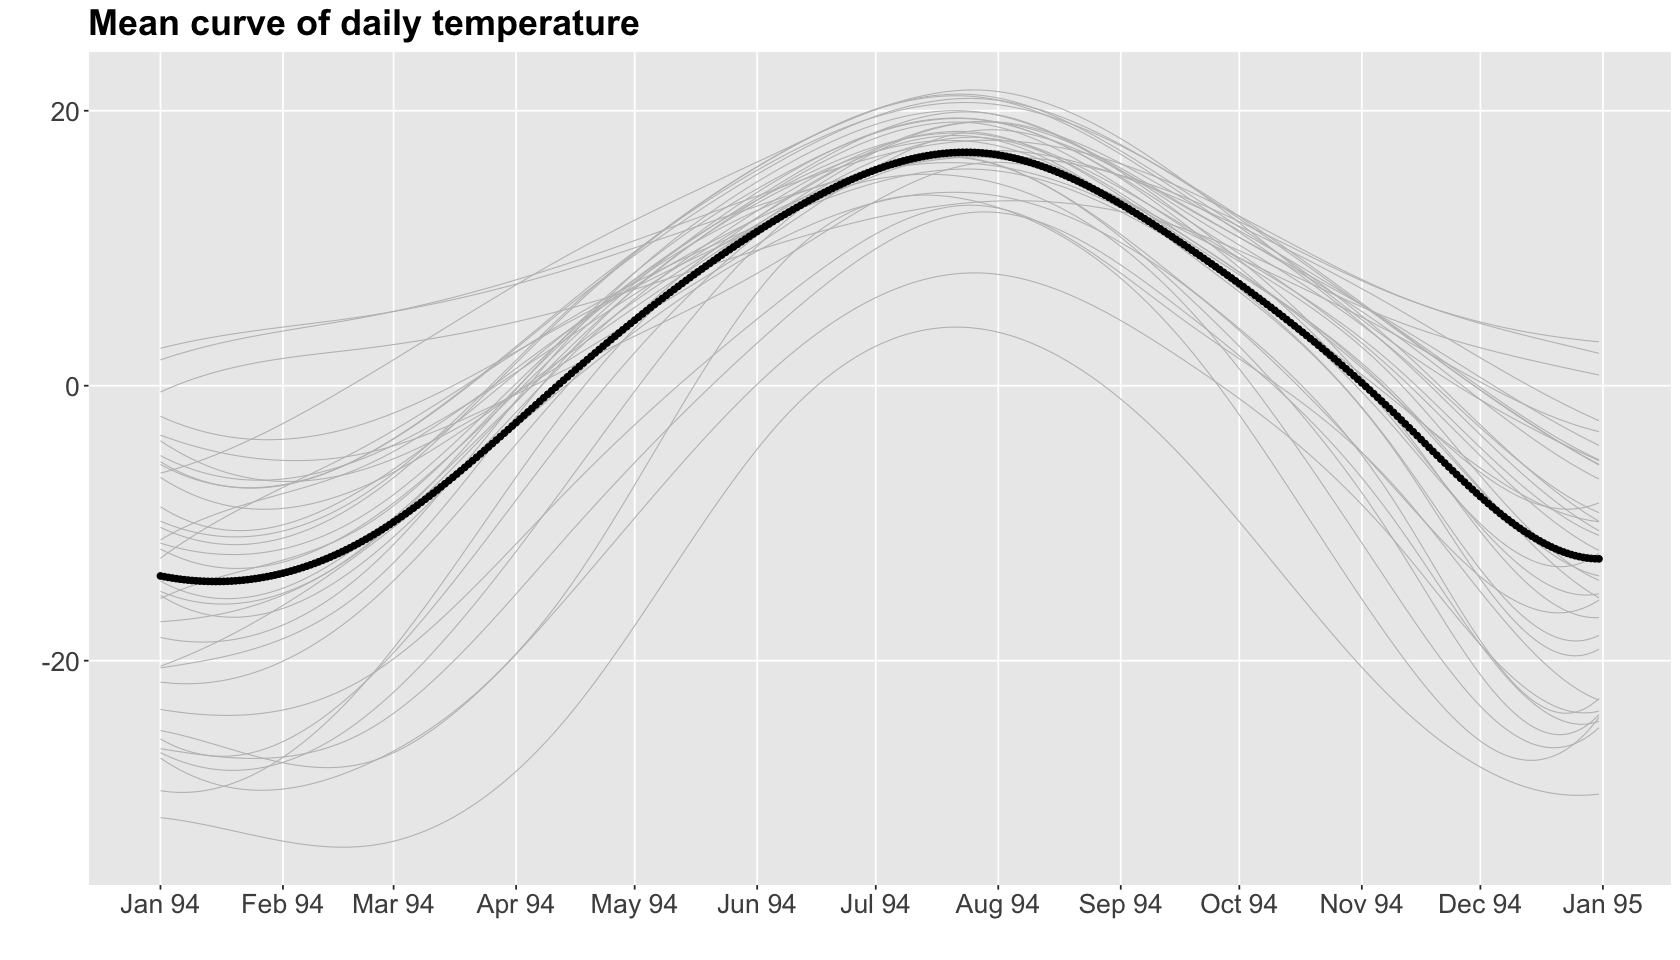

In [29]:
options(repr.plot.width=14, repr.plot.height=8)
data.frame(temp.fitted) %>%
  mutate(date = temp.date) %>%
  gather(key = "city", value = "temp", -date) %>%
  ggplot(aes(x = date, y = temp)) +
    geom_line(aes(group = city), color="grey", size = 0.3) + 
    labs(x="",y="", title="Mean curve of daily temperature") +
    font_theme + theme(legend.position = "none") +
    scale_x_date(date_labels = "%b %y", date_breaks="month")+
    geom_point(data=data.frame(mean=temp.mean.fitted, date=temp.date), aes(x=date,y=mean))

### Functional standard deviation

[1] "done"

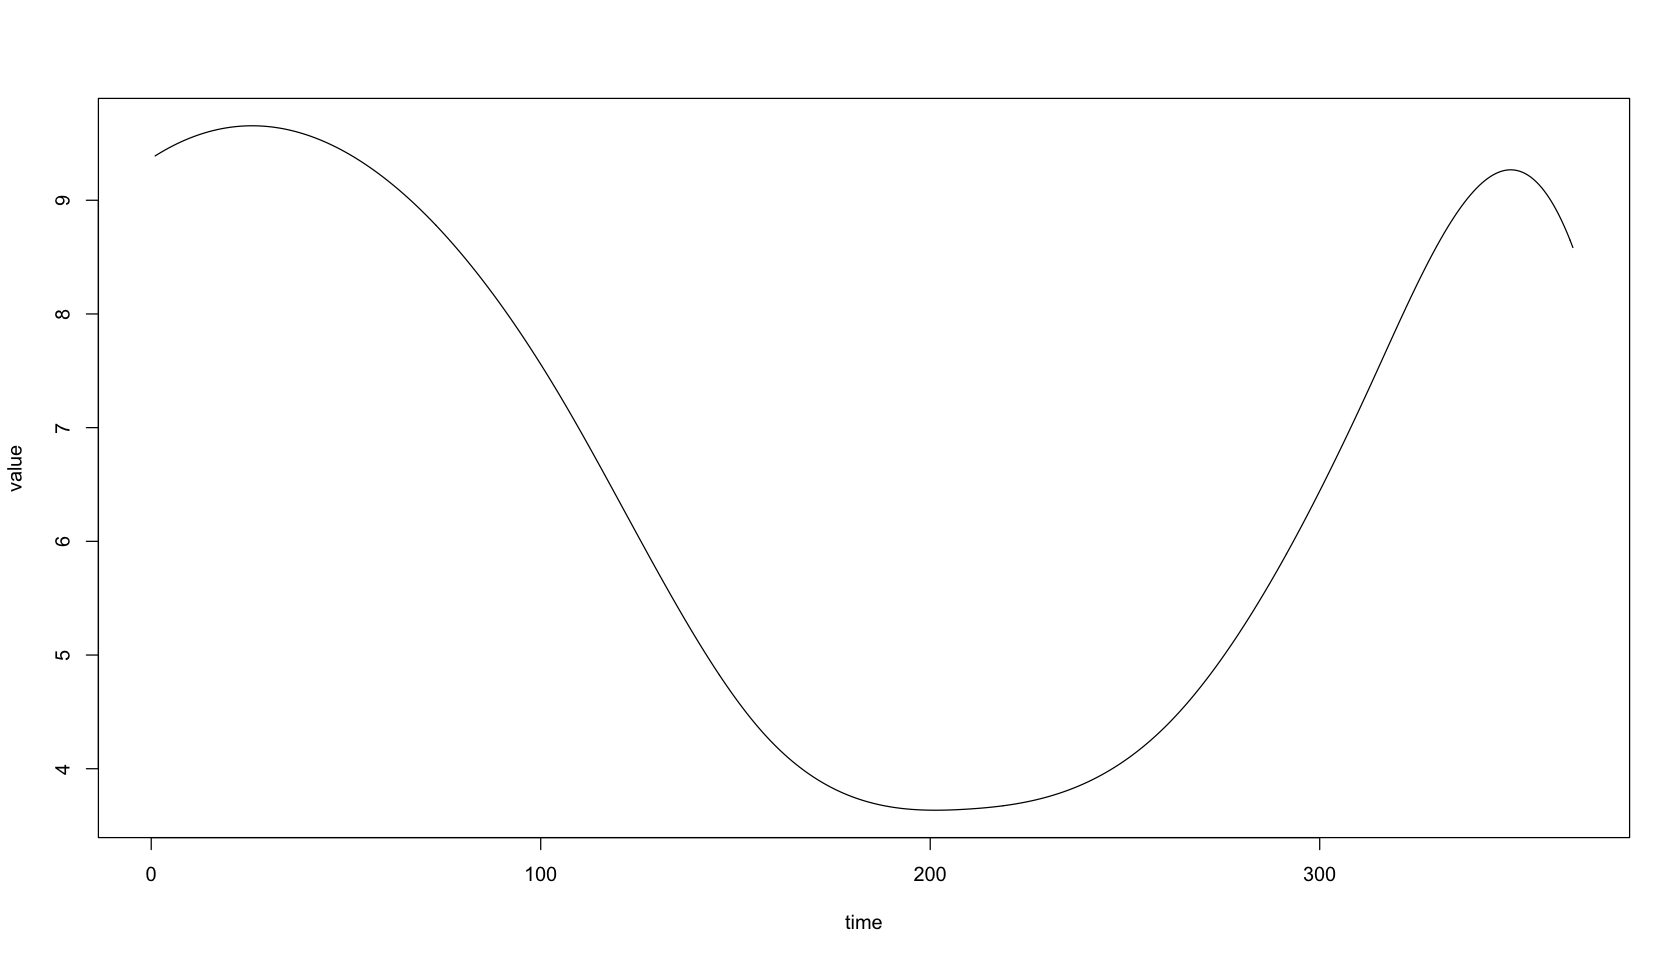

In [30]:
temp.std <- std.fd(temp.smooth$fd)
options(repr.plot.width=14, repr.plot.height=8)
plot(temp.std)

### Functional covariance and corrrelation

In [31]:
temp.time <- seq(1,365,3) 
temp.var  <- var.fd(temp.smooth$fd)
temp.cov  <- eval.bifd(temp.time, temp.time, temp.var)
temp.cor  <- cor.fd(temp.time,temp.smooth$fd)

[1] "bifd"


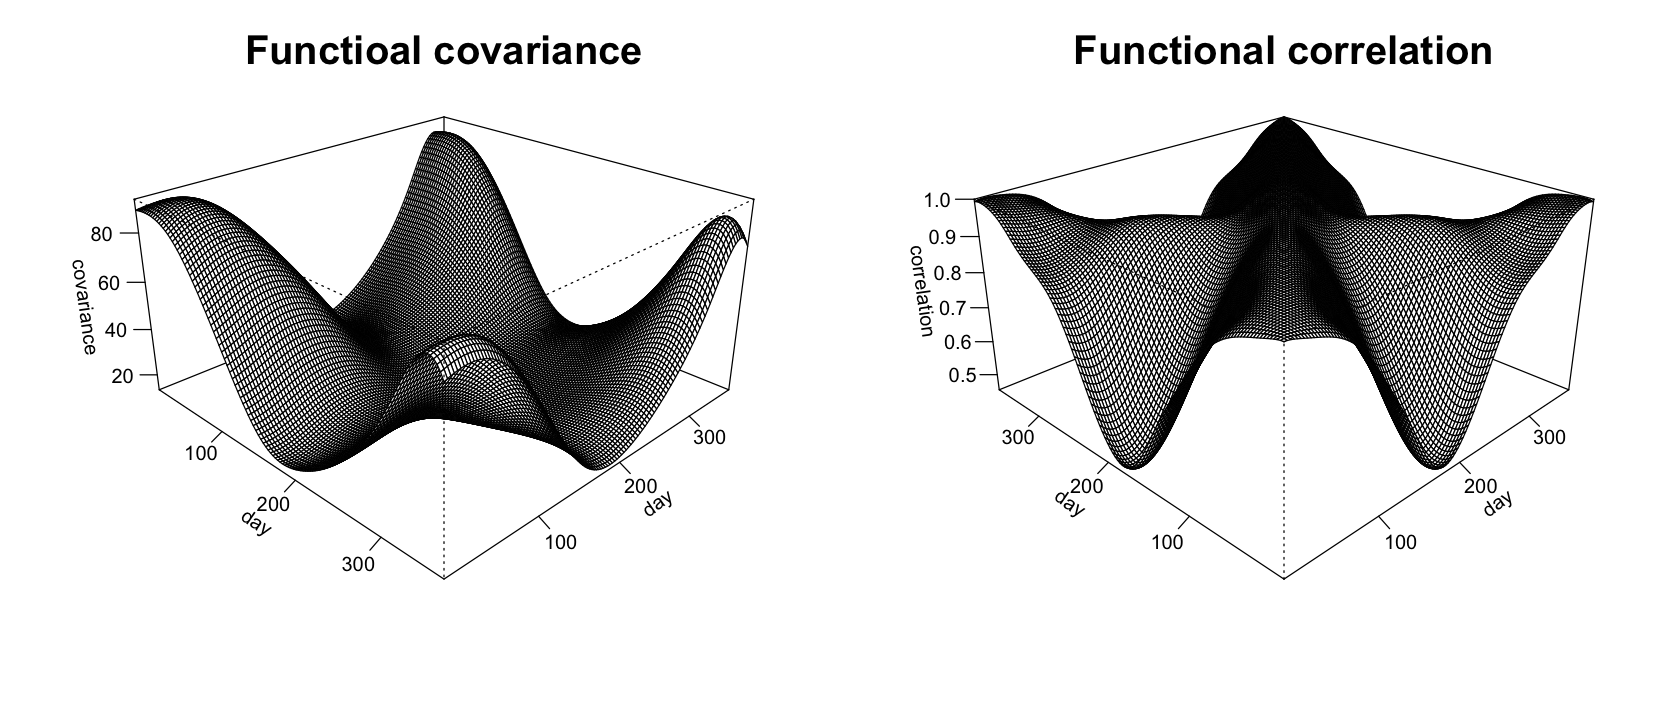

In [32]:
options(repr.plot.width=14, repr.plot.height=6)
par(mfrow=c(1,2))
persp(temp.time, temp.time, temp.cov, theta=45, phi=25, r=3, expand = 0.5, ticktype="detailed",
      xlab="day", ylab="day", zlab="covariance")
title("Functioal covariance", cex.main=2)
persp(temp.time, temp.time, temp.cor, theta=-45, phi=25, r=3, expand = 0.5, ticktype="detailed",
      xlab="day", ylab="day", zlab="correlation")
title("Functional correlation", cex.main=2)
par(mfrow=c(1,1))